In [2]:
%pylab inline
import networkx as nx
from networkx.algorithms import bipartite
import pandas as pd
import gzip
import pickle
import random
import seaborn 


Populating the interactive namespace from numpy and matplotlib


We use organisms that have >80% coverage and more than 1000 proteins in the proteome. 
These are saved from another notebook titled **parse_pfam_index**. 
Some relevant stats are given there.

In [3]:
organisms = pickle.load(open('organisms.pkl', 'rb'))
print ('there are {} organisms in the set'.format(len(organisms)))

there are 2266 organisms in the set


These are the c-d-GMP **binding** domains. 
There are many more that are c-d-GMP **associated**, but these are those with experimental evidence (says Melene)
  
  * PilZ  [PF07238](http://pfam.xfam.org/family/PF07238)
  * GGDEF [PF00990](http://pfam.xfam.org/family/ggdef)
  * GIL [PF10995](http://pfam.xfam.org/family/PF10995)
  * EAL [PF00563](http://pfam.xfam.org/family/PF00563)
  * HD_5, PF13487
  * FleQ, PF06490
  * MshEN, PF05157


  * PilZ_2 [PF16823](http://pfam.xfam.org/family/PF16823)

In [4]:
relevant_domains = {
    'PF07238':'PilZ', 
    'PF00990':'GGDEF', 
    'PF00563':'EAL',
    'PF10995':'GIL',
    'PF13487':'HD_5',
    'PF06490':'FleQ',
    'PF05157':'MshEN'
}

In [5]:
# load data from pickle
data = pickle.load(open('data.pkl', 'rb'))
data.describe()

,nproteins,ndomains,ncomps,majorcomp,PilZ,GGDEF,EAL,GIL,HD_5,FleQ,...,MshEN_n,MshEN_bc,MshEN_ec,FleQ_k,FleQ_c,FleQ_n,FleQ_bc,FleQ_ec,GIL_k,GIL_n
count,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,2266.000000,...,1113.000000,149.000000,1.490000e+02,203.000000,202.000000,203.00000,192.0,192.000000,74.0,74.0
mean,2816.634157,1818.064431,1165.292586,74.719329,1.990291,13.271845,7.161077,0.032657,1.106355,0.090909,...,11.803235,0.362275,3.306390e-01,1.940887,0.950495,109.26601,0.0,0.015009,0.0,1.0
std,1141.722047,410.401002,260.825043,52.311773,2.909206,15.676427,8.831766,0.177776,1.928910,0.292113,...,39.599568,0.469166,3.247544e-01,0.256506,0.217459,40.62675,0.0,0.024782,0.0,0.0
min,823.000000,697.000000,463.000000,8.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,1.000000,0.000000,6.331922e-07,0.000000,0.000000,1.00000,0.0,0.003978,0.0,1.0
25%,1914.500000,1499.250000,960.000000,39.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,1.494365e-02,2.000000,1.000000,78.00000,0.0,0.009430,0.0,1.0
50%,2702.000000,1840.000000,1168.000000,57.000000,1.000000,8.000000,4.000000,0.000000,0.000000,0.000000,...,2.000000,0.000000,1.436266e-01,2.000000,1.000000,111.00000,0.0,0.011736,0.0,1.0
75%,3513.500000,2127.750000,1373.000000,96.000000,3.000000,20.000000,11.000000,0.000000,1.000000,0.000000,...,2.000000,1.000000,7.071068e-01,2.000000,1.000000,138.00000,0.0,0.015391,0.0,1.0
max,12055.000000,3204.000000,2010.000000,341.000000,22.000000,113.000000,57.000000,1.000000,14.000000,2.000000,...,335.000000,1.000000,7.071068e-01,2.000000,1.000000,224.00000,0.0,0.342672,0.0,1.0


In [6]:
allnames = data.index
exist = dict()
for name in allnames :
    shortname = ' '.join(name.split()[:2])
    if shortname not in exist :
        exist[shortname] = ( name, data.loc[name]['ndomains'] )
    
    elif data.loc[name]['ndomains'] > exist[shortname][1] :
            exist[shortname] = ( name, data.loc[name]['ndomains'] )
        

touse = [exist[shortname][0] for shortname in exist]
b=data.loc[touse]
b.index = [' '.join(name.split()[:2]) for name in b.index]
b
data = b

In [7]:
len(data)

1780

In [36]:
data.to_csv('data.csv')

### Testing for normality

Here we use the [Shaphiro-Wilk test](https://en.wikipedia.org/wiki/Shapiro%E2%80%93Wilk_test) to look at the distribution of each feature we measured to see if they are normally distributed or not. Those with **small p values** are not likely to be normally distributed. 

In [5]:
from scipy.stats import shapiro
for feature in data.columns :
    if '_' in feature :
        x = data[feature].dropna()
        
        if len(x)>10 and std(x) >0.01: 
            x -= mean(x)
            x /= std(x)    
            pval = shapiro (x )[1]
            print ('{} : {}'.format(feature, pval))
    

HD_5 : 0.0
PilZ_k : 4.297001160585159e-36
PilZ_c : 4.203895392974451e-45
PilZ_n : 0.0
PilZ_bc : 2.1417665443073871e-19
PilZ_ec : 1.965242194932479e-20
GGDEF_k : 1.7985117751212572e-25
GGDEF_c : 3.9950443990486123e-35
GGDEF_n : 2.7520045557270316e-30
GGDEF_bc : 3.8799838516473054e-39
GGDEF_ec : 1.3469335326049693e-28
EAL_k : 1.7844880844533574e-28
EAL_c : 1.2059692599638752e-26
EAL_n : 7.721360092133315e-29
EAL_bc : 0.0
EAL_ec : 1.1740840585278546e-29
HD_5_k : 2.820601751083391e-31
HD_5_c : 1.6776915453060807e-32
HD_5_n : 2.4983572498704406e-28
HD_5_bc : 2.475864543021548e-34
HD_5_ec : 3.902933624969677e-27
MshEN_k : 0.0
MshEN_c : 0.0
MshEN_n : 0.0
MshEN_bc : 1.417749188735467e-17
MshEN_ec : 1.3538258886072307e-15
FleQ_k : 4.063280292867039e-28
FleQ_c : 2.9086845689831618e-28
FleQ_n : 0.9550727009773254
FleQ_ec : 4.385525446714453e-28


In [12]:
# extract coarse feature matrix

X = data[list(relevant_domains.values())].values


In [14]:
from sklearn.cluster import KMeans

n_clusters = 5
cls = KMeans(n_clusters, n_jobs=-1)
y = cls.fit_predict(X)



In [15]:
from sklearn.decomposition import PCA

pca = PCA()
pca.fit(X)
pca.explained_variance_

array([ 335.37047,    7.90191,    5.14303,    2.24608,    1.22233,
          0.06263,    0.02935])

In [16]:
from sklearn.cluster import DBSCAN
from sklearn import metrics
db = DBSCAN(min_samples=10).fit(X)
len(set(db.labels_))

len(db.labels_)
len(data.index)

1780

In [10]:
coarse = dict()
for sp, gr in zip(data.index, db.labels_) :
    if gr >=0 :
        coarse[sp] = gr



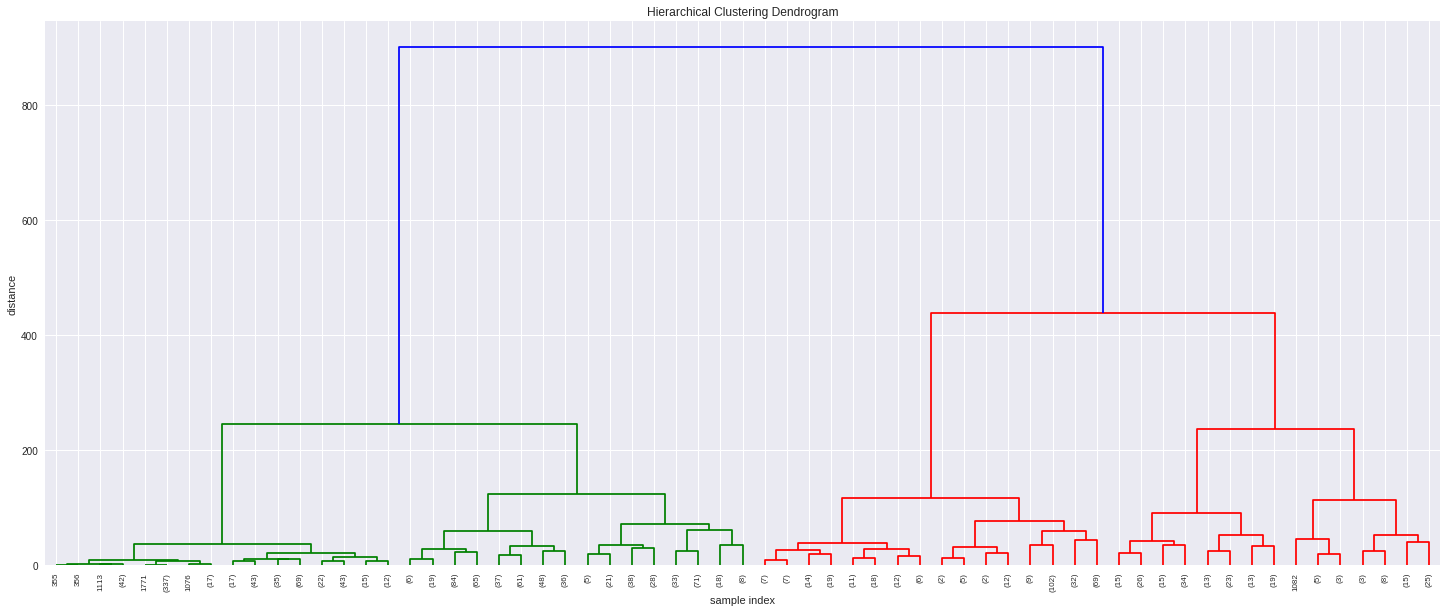

In [17]:
from scipy.cluster.hierarchy import dendrogram, linkage, cophenet
from scipy.spatial.distance import pdist
np.set_printoptions(precision=5, suppress=True)
Z = linkage(X, 'ward')

# calculate full dendrogram
plt.figure(figsize=(25, 10))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
clstr= dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=8.,  # font size for the x axis labels
    truncate_mode='level',
    p=5
)
plt.show()


In [19]:
def fancy_dendrogram(*args, **kwargs):
    max_d = kwargs.pop('max_d', None)
    if max_d and 'color_threshold' not in kwargs:
        kwargs['color_threshold'] = max_d
    annotate_above = kwargs.pop('annotate_above', 0)

    ddata = dendrogram(*args, **kwargs)

    if not kwargs.get('no_plot', False):
        plt.title('Hierarchical Clustering Dendrogram (truncated)')
        plt.xlabel('sample index or (cluster size)')
        plt.ylabel('distance')
        for i, d, c in zip(ddata['icoord'], ddata['dcoord'], ddata['color_list']):
            x = 0.5 * sum(i[1:3])
            y = d[1]
            if y > annotate_above:
                plt.plot(x, y, 'o', c=c)
                plt.annotate("%.3g" % y, (x, y), xytext=(0, -5),
                             textcoords='offset points',
                             va='top', ha='center')
        if max_d:
            plt.axhline(y=max_d, c='k')
    return ddata

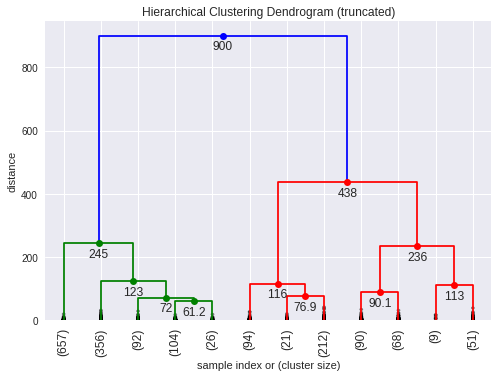

In [28]:

fancy_dendrogram(
    Z,
    truncate_mode='lastp',
    p=12,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    annotate_above=10,  # useful in small plots so annotations don't overlap
)
plt.show()

In [52]:
from scipy.cluster.hierarchy import inconsistent
from scipy.cluster.hierarchy import fcluster

max_d = 200

clusters = fcluster(Z, max_d, criterion='distance')

max(clusters)
clusters

data['coarse']=clusters
data[data['coarse']==5] [list(relevant_domains.values())]


,PilZ,GGDEF,EAL,GIL,HD_5,FleQ,MshEN
Acetobacterium woodii,0,61,21,0,8,0,2
Acidovorax sp.,5,91,45,1,5,0,4
Actinoplanes friuliensis,1,79,54,0,0,0,2
Alteromonas naphthalenivorans,5,60,31,0,3,1,2
Aquitalea magnusonii,5,52,32,0,11,0,1
Azoarcus sp.,7,76,47,0,11,0,4
Dechloromonas aromatica,6,57,31,0,13,0,6
Dechloromonas denitrificans,6,56,31,0,11,0,7
Dechlorosoma suillum,6,57,39,0,10,0,5
Desulfuromonas acetoxidans,7,82,37,0,5,0,4


In [ ]:
from scipy.spatial.distance import pdist,squareform

?seaborn.matrix.heatmap(squareform(pdist(X)))
#matshow(squareform(pdist(X)))

In [66]:
b=data['coarse']
b.to_csv('hierarchical')
data.to_csv('unique_data.csv')

In [60]:
import scipy.cluster.hierarchy as sch

'''
dM is the square distance matrix
'''
def plot_hierarchical_clustering(dM, labels=None, savefig=None):
    fig = plt.figure(figsize=(8,8))
    axdendro = fig.add_axes([0.1,0.8,0.8,0.2])
    Y = sch.linkage(dM, method='ward') # You can try alternative linkage methods here
    Z = sch.dendrogram(Y, orientation='top')#, truncate_mode='lastp',    p=12,)
    axdendro.set_xticks([])
    #axdendro.set_yticks([])

    # Plot distance matrix.
    axmatrix = fig.add_axes([0.1,0.01,0.8,0.8])
    index = Z['leaves']
    dM = dM[index,:]
    dM = dM[:,index]
    im = axmatrix.matshow(dM, aspect='auto', origin='lower', cmap='Blues')
    axmatrix.set_xticks([])
    if labels is not None:
        labels = [labels[i] for i in index]
        axmatrix.set_yticks(range(0,len(labels)))
        axmatrix.set_yticklabels(labels)
    else:
        axmatrix.set_yticks([])

    # Plot colorbar.
    axcolor = fig.add_axes([0.91,0.01,0.02,0.8])
    plt.colorbar(im, cax=axcolor)
    if savefig is not None:
        plt.savefig(savefig, bbox_inches='tight', dpi=300)
    return Y


/usr/lib/python3.6/site-packages/ipykernel/__main__.py:9: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix


array([[     0.     ,      4.     ,      0.     ,      2.     ],
       [     3.     ,    189.     ,      0.     ,      2.     ],
       [    46.     ,   1780.     ,      0.     ,      3.     ],
       ..., 
       [  3553.     ,   3554.     ,  12502.32961,    336.     ],
       [  3552.     ,   3555.     ,  13188.19833,   1444.     ],
       [  3556.     ,   3557.     ,  29711.67696,   1780.     ]])

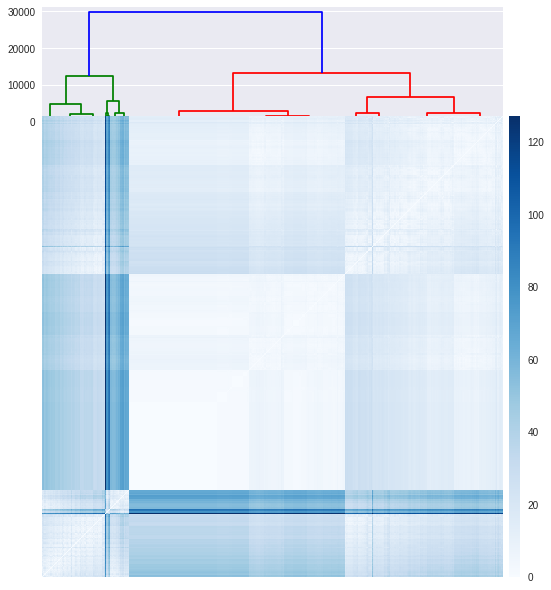

In [61]:
from scipy.spatial.distance import pdist,squareform

plot_hierarchical_clustering(squareform(pdist(X)))


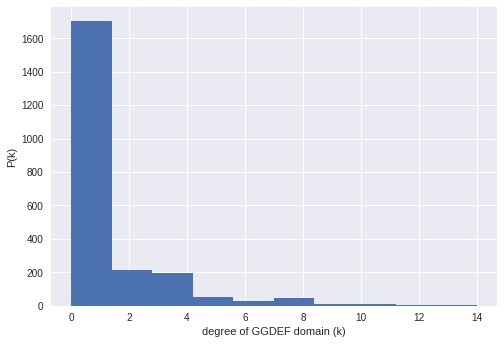

In [37]:

b=data['HD_5']


# [make a dataframe called df]
b.hist(  )
xlabel('degree of GGDEF domain (k)')
ylabel('P(k)')



In [15]:
a.describe()


,nproteins,ndomains,ncomps,majorcomp,PilZ_k,PilZ_n,GGDEF_k,GGDEF_n,EAL_k,EAL_n
count,100.000000,100.00000,100.000000,100.000000,34.000000,34.000000,63.000000,63.000000,55.000000,55.000000
mean,2601.730000,1707.40000,1098.800000,64.160000,0.882353,9.764706,7.380952,66.365079,5.945455,74.290909
std,1163.679274,428.05154,268.783943,50.352639,1.249599,24.046746,6.284719,63.777916,4.855002,64.266423
min,875.000000,769.00000,540.000000,13.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000
25%,1588.250000,1330.75000,869.750000,34.000000,0.000000,1.000000,2.000000,5.500000,2.000000,39.500000
50%,2405.000000,1743.00000,1114.500000,48.000000,1.000000,2.000000,7.000000,53.000000,5.000000,58.000000
75%,3254.000000,2087.75000,1350.500000,72.250000,1.000000,2.000000,11.000000,96.000000,8.000000,104.500000
max,5892.000000,2534.00000,1685.000000,280.000000,6.000000,109.000000,25.000000,280.000000,23.000000,280.000000


In [118]:
g.nodes()[0]
g['C7RIB6']

{'PF00308': {'bitscore': 279.0, 'evalue': 4.3e-80},
 'PF08299': {'bitscore': 106.0, 'evalue': 1.1e-27},
 'PF11638': {'bitscore': 64.1, 'evalue': 1.1e-14}}